# _(Brette, et, al., 2007)_ CUBA

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

In [1]:
import numpy as np
import brainpy as bp

In [2]:
bp.profile.set(jit=True, dt=0.1)

In [3]:
num_exc = 3200
num_inh = 800
taum = 20
taue = 5
taui = 10
Vt = -50
Vr = -60
El = -49
we = 60 * 0.27 / 10  # excitatory synaptic weight (voltage)
wi = -20 * 4.5 / 10  # inhibitory synaptic weight
ref = 5.0

In [4]:
neu_ST = bp.types.NeuState('V', 'sp', 'ge', 'gi', sp_t=-1e7)

@bp.integrate
def int_ge(ge, t):
    return -ge / taue


@bp.integrate
def int_gi(gi, t):
    return -gi / taui


@bp.integrate
def int_V(V, t, ge, gi):
    return (ge + gi - (V - El)) / taum


def neu_update(ST, _t):
    ST['ge'] = int_ge(ST['ge'], _t)
    ST['gi'] = int_gi(ST['gi'], _t)

    if _t - ST['sp_t'] > ref:
        V = int_V(ST['V'], _t, ST['ge'], ST['gi'])
        if V >= Vt:
            ST['V'] = Vr
            ST['sp'] = 1.
            ST['sp_t'] = _t
        else:
            ST['V'] = V
            ST['sp'] = 0.
    else:
        ST['sp'] = 0.


neuron = bp.NeuType(name='CUBA', ST=neu_ST, steps=neu_update, mode='scalar')

In [5]:
def update1(pre, post, pre2post):
    for pre_id in range(len(pre2post)):
        if pre['sp'][pre_id] > 0.:
            post_ids = pre2post[pre_id]
            for i in post_ids:
                post['ge'][i] += we


exc_syn = bp.SynType('exc_syn',
                     steps=update1,
                     ST=bp.types.SynState())

In [6]:
def update2(pre, post, pre2post):
    for pre_id in range(len(pre2post)):
        if pre['sp'][pre_id] > 0.:
            post_ids = pre2post[pre_id]
            for i in post_ids:
                post['gi'][i] += wi


inh_syn = bp.SynType('inh_syn',
                     steps=update2,
                     ST=bp.types.SynState())

In [7]:
group = bp.NeuGroup(neuron,
                    geometry=num_exc + num_inh,
                    monitors=['sp'])
group.ST['V'] = Vr + np.random.rand(num_exc + num_inh) * (Vt - Vr)

exc_conn = bp.SynConn(exc_syn,
                      pre_group=group[:num_exc],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=0.02))

inh_conn = bp.SynConn(inh_syn,
                      pre_group=group[num_exc:],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=0.02))

Compilation used 0.5348 s.
Start running ...
Run 10.0% used 0.013 s.
Run 20.0% used 0.025 s.
Run 30.0% used 0.036 s.
Run 40.0% used 0.046 s.
Run 50.0% used 0.057 s.
Run 60.0% used 0.068 s.
Run 70.0% used 0.079 s.
Run 80.0% used 0.090 s.
Run 90.0% used 0.100 s.
Run 100.0% used 0.111 s.
Simulation is done in 0.111 s.


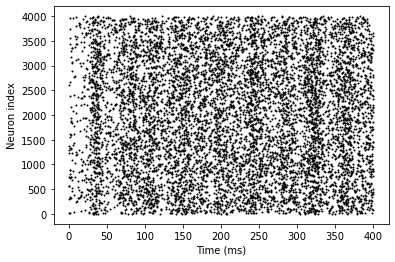

In [9]:
net = bp.Network(group, exc_conn, inh_conn)
net.run(400., report=True)
bp.visualize.raster_plot(net.ts, group.mon.sp, show=True)